# Final analysis

This notebook contains the final form of our analysis as well as the final form of the data cleaning process.

In [1]:
from utils import *
from sklearn.linear_model import LogisticRegression
from os import listdir
from pathlib import Path

In [2]:
path = r'/home/daniel/code/costofcare/data/bhp_ukhls_data_stata/UKDA-6614-stata/stata/ukhls'
my_colnames = [
                'hidp',
                'sex',
                'jbnssec_dv',
                'jbnssec8_dv',
                'fimnlabgrs_dv',
                'jbstat',
                'jbhrs',
                'jbft_dv',
                'ethn_dv',
                'dvage',
                'mastat_dv',
                'country',
                'aidhh',
                'aidhrs',
                'aidxhh',
                'paygu_dv',
                'qfhigh',
                'qfhigh_dv',
                'istrtdatm',
                'istrtdaty',
                'month',
                'indscus_xw',
                'indinus_lw',
                'indinub_lw',
                'indinui_lw'
]

In [3]:
data = load_data(path, my_colnames)

/home/daniel/code/costofcare/src/utils.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wave'] = i+1


In [4]:
path = r'/home/daniel/code/costofcare/data/bhp_ukhls_data_stata/UKDA-6614-stata/stata/ukhls'
my_colnames = ['hidp', 'fihhmngrs_dv']
data_h = load_data_h(path, my_colnames)

In [5]:
data = pd.merge(data, data_h, on=['hidp', 'wave'])

In [6]:
cpih = pd.read_csv('../data/cpih_uk_88_23.csv')
data_clean = recoding_and_cleaning(data, cpih)

/home/daniel/code/costofcare/src/utils.py:448: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['jbhrs_clean'][data.jbhrs_clean < 1] = np.nan


<Axes: >

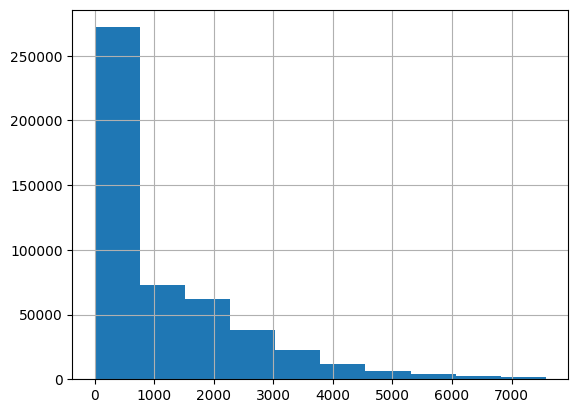

In [7]:
data_clean.ind_inc_deflated.hist()

In [8]:
data_clean['treated'] = data_clean['aidhrs_recoded_3'].transform(pd.notnull)
data_clean['control'] = data_clean['aidhrs'] == 'inapplicable'
data_clean['ever_treated'] = data_clean.groupby('pidp')['treated'].transform(any).values

In [9]:
data_clean['edu_3'] = data_clean.edu_3.replace({1.0: 'low', 2.0:'middle', 3.0:'high'})

In [10]:
data_clean.employed.value_counts()

employed
employed        276897
unemployed      223525
inapplicable         1
Name: count, dtype: int64

In [11]:
dummies = pd.get_dummies(data_clean.ethn_5)
edu_dumm = pd.get_dummies(data_clean.edu_3)
data_final = pd.concat([data_clean, dummies, edu_dumm], axis=1)

In [12]:
data_final['inc_share'] = (data_final['ind_inc_deflated'] / data_final['hh_inc_deflated']) * 100

In [13]:
data_final.loc[data_final['inc_share'] > 100, 'inc_share'] = np.nan

### Prob of employment calculation

<Axes: >

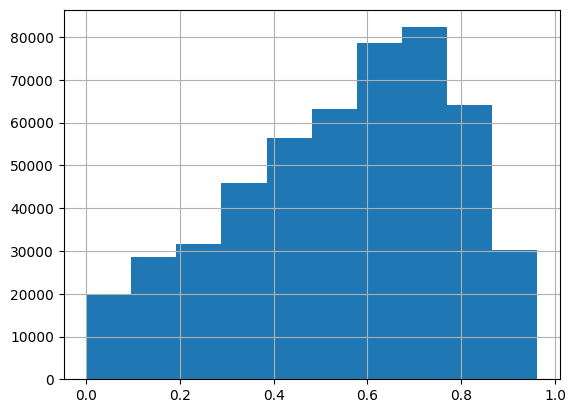

In [14]:
df = data_final.copy()
df['employed'] = df.employed.replace({"inapplicable": np.nan,
                                     'employed': 1,
                                     'unemployed': 0})
years = df.year.dropna().unique()
out = df[['pidp', 'year']]
for year in years:
    df_year = df[df.year==year][['pidp', 'year', 'employed', 'treated', 'dvage', 'sex_recoded', 'asian', 'black', 'mixed', 'other', 'high', 'middle', 'mastat_recoded']].dropna()
    y_year = df_year['employed']
    X_year = df_year[['treated', 'dvage', 'sex_recoded', 'asian', 'black', 'mixed', 'other', 'high', 'middle', 'mastat_recoded']]
    clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_year, y_year)
    df_year['prob_employed'] = [x[1] for x in clf.predict_proba(X_year)]
    out = out.merge(df_year[['pidp', 'year', 'prob_employed']], on=['pidp', 'year'], how='outer', suffixes=(None, year))
out['prob_emp'] = out.iloc[:, 2:].sum(axis=1)
out = out[['pidp', 'year', 'prob_emp']]
out.prob_emp.hist()

In [15]:
data_final = data_final.merge(out, on=['pidp', 'year']).copy()
treated_f = data_final[data_final.ever_treated].copy()
control_f = data_final[~data_final.ever_treated].copy()

In [16]:
print(set(control_f.pidp.unique()) & set(treated_f.pidp.unique()))
common_elements = [item for item in control_f.pidp.unique() if item in treated_f.pidp.unique()]
print(any(common_elements))

set()
False


In [17]:
treated_f.to_csv('../data/treated_cases.csv')
control_f.to_csv('../data/control_cases.csv')

In [17]:
conds = {
    'employed': False,
    'dropna': True,
    'target_var': 'ind_inc_deflated',
    'min_treat_waves': 1,
    'min_waves_pretreat': 3
}
treated_ii, control_ii = isc_data_preparation(data_final, conds)
treated_ii.to_csv('../data/strata/ii_t_full.csv')
control_ii.to_csv('../data/strata/ii_c_full.csv')

In [22]:
conds = {
    'employed': False,
    'dropna': True,
    'target_var': 'hh_inc_deflated',
    'min_treat_waves': 1,
    'min_waves_pretreat': 3
}
treated_hhi, control_hhi = isc_data_preparation(data_final, conds)
treated_hhi.to_csv('../data/strata/hhi_t_full.csv')
control_hhi.to_csv('../data/strata/hhi_c_full.csv')

In [18]:
conds = {
    'employed': False,
    'dropna': True,
    'target_var': 'inc_share',
    'min_treat_waves': 1,
    'min_waves_pretreat': 3
}
treated_is, control_is = isc_data_preparation(data_final, conds)
treated_is.to_csv('../data/strata/is_t_full.csv')
control_is.to_csv('../data/strata/is_c_full.csv')

In [ ]:
conds = {
    'employed': False,
    'dropna': True,
    'target_var': 'prob_emp',
    'min_treat_waves': 1,
    'min_waves_pretreat': 3
}
treated_pe, control_pe = isc_data_preparation(data_final, conds)
treated_pe.to_csv('../data/strata/pe_t_full.csv')
control_pe.to_csv('../data/strata/pe_c_full.csv')

In [19]:
def get_intensity_4(t_df, outname):
    dummies = pd.get_dummies(t_df.aidhrs_recoded_4)
    treated_d = pd.concat([t_df, dummies], axis=1)
    idx = treated_d[treated_d.year == treated_d.year_treated]
    idxl = idx[idx['0-4']==1].pidp
    idxml = idx[idx['5-19']==1].pidp
    idxmh = idx[idx['20-49']==1].pidp
    idxh = idx[idx['50+']==1].pidp
    treated_d[treated_d.pidp.isin(idxl)].to_csv(f'../data/strata/{outname}_li.csv')
    treated_d[treated_d.pidp.isin(idxml)].to_csv(f'../data/strata/{outname}_mli.csv')
    treated_d[treated_d.pidp.isin(idxmh)].to_csv(f'../data/strata/{outname}_mhi.csv')
    treated_d[treated_d.pidp.isin(idxh)].to_csv(f'../data/strata/{outname}_hi.csv')
    return

In [20]:
def get_intensity_2(t_df, outname):
    dummies = pd.get_dummies(t_df.aidhrs_recoded_4)
    treated_d = pd.concat([t_df, dummies], axis=1)
    idx = treated_d[treated_d.year == treated_d.year_treated]
    idxl = idx[idx['0-4']==1].pidp
    idxml = idx[idx['5-19']==1].pidp
    idxmh = idx[idx['20-49']==1].pidp
    idxh = idx[idx['50+']==1].pidp
    treated_d[treated_d.pidp.isin(idxl) | treated_d.pidp.isin(idxml)].to_csv(f'../data/strata/{outname}_low.csv')
    treated_d[treated_d.pidp.isin(idxh) | treated_d.pidp.isin(idxmh)].to_csv(f'../data/strata/{outname}_high.csv')
    return

In [23]:
treated_ii = pd.read_csv('../data/strata/ii_t_full.csv')
get_intensity_4(treated_ii, 'ii_t')

treated_hhi = pd.read_csv('../data/strata/hhi_t_full.csv')
get_intensity_4(treated_hhi, 'hhi_t')

treated_is = pd.read_csv('../data/strata/is_t_full.csv')
get_intensity_4(treated_is, 'is_t')

/tmp/ipykernel_5938/1489806817.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  treated_hhi = pd.read_csv('../data/strata/hhi_t_full.csv')


In [25]:
treated_ii = pd.read_csv('../data/strata/ii_t_full.csv')
get_intensity_2(treated_ii, 'ii_t')

In [ ]:
treated_ii_3 = pd.read_csv('./strata/ii_t_full_3.csv')
get_intensity_4(treated_ii_3, 'ii_t_3')

## Stratification

In [24]:
def get_strata(data_folder_path, out_folder):
    for filename in listdir(data_folder_path):
        pre_fix = Path(filename).stem

        data = pd.read_csv(f'{data_folder_path}/{filename}')
    
        data[data.sex=='female'].to_csv(f'{out_folder}/{pre_fix}_f.csv')
        data[data.sex=='male'].to_csv(f'{out_folder}/{pre_fix}_m.csv')

        data[data.ethn_5=='white'].to_csv(f'{out_folder}/{pre_fix}_w.csv')
        data[data.ethn_5!='white'].to_csv(f'{out_folder}/{pre_fix}_nw.csv')

        data[data.ethn_5=='white'].to_csv(f'{out_folder}/{pre_fix}_w.csv')
        data[data.ethn_5!='white'].to_csv(f'{out_folder}/{pre_fix}_nw.csv')

        data[data.edu_3=='low'].to_csv(f'{out_folder}/{pre_fix}_edl.csv')
        data[data.edu_3=='middle'].to_csv(f'{out_folder}/{pre_fix}_edm.csv')
        data[data.edu_3=='high'].to_csv(f'{out_folder}/{pre_fix}_edh.csv')

        data[data.mastat_recoded==1].to_csv(f'{out_folder}/{pre_fix}_mar.csv')
        data[data.mastat_recoded==0].to_csv(f'{out_folder}/{pre_fix}_sin.csv')
    return

In [25]:
get_strata('/home/daniel/code/costofcare/data/strata', '../data/sub_strata')

/tmp/ipykernel_5938/3268863529.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'{data_folder_path}/{filename}')
/tmp/ipykernel_5938/3268863529.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'{data_folder_path}/{filename}')
/tmp/ipykernel_5938/3268863529.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'{data_folder_path}/{filename}')


In [26]:
import os

directory_path = "../data/sub_strata/"
files = os.listdir(directory_path)
for file in files:
    if "_t_" in file:
        shards = file.split("_")
        file_name_c = f'{shards[0]}_c_full_{shards[3]}'
        t_data = pd.read_csv(f'{directory_path}{file}', index_col=0)
        c_data = pd.read_csv(f'{directory_path}{file_name_c}', index_col=0)
        t_data['treatment_group'] = True
        c_data['treatment_group'] = False
        out = pd.concat([t_data, c_data])
        out.to_csv(f'../data/full_strata/{shards[0]}_{shards[2]}_{shards[3]}')


/tmp/ipykernel_5938/3802636666.py:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  t_data = pd.read_csv(f'{directory_path}{file}', index_col=0)
/tmp/ipykernel_5938/3802636666.py:10: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  c_data = pd.read_csv(f'{directory_path}{file_name_c}', index_col=0)
/tmp/ipykernel_5938/3802636666.py:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  t_data = pd.read_csv(f'{directory_path}{file}', index_col=0)
/tmp/ipykernel_5938/3802636666.py:10: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  c_data = pd.read_csv(f'{directory_path}{file_name_c}', index_col=0)
/tmp/ipykernel_5938/3802636666.py:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  t_data = pd.read_csv(f'{directory_path}{file}